In [1]:
include("TYUtils.jl")
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using Printf
using LinearAlgebra: ldiv!
using .TYUtils: decompose_balanced_wave, compute_balanced_basis, compute_wave_bases

function get_vars(solution, grid)
    ζt = Array{Float64}(undef, (grid.nx, grid.ny))
    qc = Array{Float64}(undef, (grid.nx, grid.ny))
    ucy = Array{Float64}(undef, (grid.nx, grid.ny))
    vcx = Array{Float64}(undef, (grid.nx, grid.ny))
    pc = Array{Float64}(undef, (grid.nx, grid.ny))
    
    ζth = deepcopy(solution[:,:,1])
    uch = deepcopy(solution[:,:,2])
    vch = deepcopy(solution[:,:,3])
    pch = deepcopy(solution[:,:,4])
    
    ldiv!(ζt, grid.rfftplan, ζth)
    ldiv!(ucy, grid.rfftplan, im * grid.l  .* uch)
    ldiv!(vcx, grid.rfftplan, im * grid.kr .* vch)
    ldiv!(pc, grid.rfftplan, pch)
    
    qc = vcx - ucy - pc
    return (ζt, qc)
end

function total_energy_spectrum(solution, grid)
    Gh, Wh = decompose_balanced_wave(solution, grid)
    Eth = grid.invKrsq .* abs2.(solution[:,:,1])
    Egh = abs2.(Gh[:,:,1]) + abs2.(Gh[:,:,2]) + abs2.(Gh[:,:,3])
    Ewh = abs2.(Wh[:,:,1]) + abs2.(Wh[:,:,2]) + abs2.(Wh[:,:,3])
    Etr = FourierFlows.radialspectrum(Eth, grid, refinement = 1)  
    Egr = FourierFlows.radialspectrum(Egh, grid, refinement = 1)
    Ewr = FourierFlows.radialspectrum(Ewh, grid, refinement = 1)
    return (Etr, Egr, Ewr)
end

function kinetic_energy_spectrum(solution, grid)
    Gh, Wh = decompose_balanced_wave(solution, grid)
    KEth =  grid.invKrsq .* abs2.(solution[:,:,1])
    KEgh = abs2.(Gh[:,:,1]) + abs2.(Gh[:,:,2])
    KEwh = abs2.(Wh[:,:,1]) + abs2.(Wh[:,:,2])
    KEtr = FourierFlows.radialspectrum(KEth, grid, refinement = 1)  
    KEgr = FourierFlows.radialspectrum(KEgh, grid, refinement = 1)
    KEwr = FourierFlows.radialspectrum(KEwh, grid, refinement = 1)
    return (KEtr, KEgr, KEwr)
end

kinetic_energy_spectrum (generic function with 1 method)

In [2]:
file = jldopen("../data/thomasyamada_data/long-run6/ty.jld2.00001000.jld2", "r")
frames = keys(file["snapshots/sol"])
t = file["snapshots/t"][frames[end]]
solution = file["snapshots/sol"][frames[end]]
nx = file["grid/nx"]
ny = file["grid/ny"]
Lx = file["grid/Lx"]
Ly = file["grid/Ly"]
close(file)
grid = TwoDGrid(CPU(); nx, Lx, ny, Ly, aliased_fraction=0, T=Float64)
file = jldopen("../data/thomasyamada_data/long-run/ty.jld2.00000100.jld2", "r")
frames = keys(file["snapshots/sol"])
t = file["snapshots/t"][frames[end]]
solution = file["snapshots/sol"][frames[end]]
close(file)

LoadError: KeyError: key "grid" not found

In [3]:
fig = Figure(size=(1200,1000), fontsize=32)
axζ = Axis(fig[1,1][1,1]; title="Barotropic vorticity", aspect=1)
axq = Axis(fig[1,2][1,1]; title="Baroclinic PV", aspect=1)
#axKEspec = Axis(fig[2,1:2];
#        xlabel = "Radial wavenumber",
#        ylabel = "Energy density",
#        xscale = log10,
#        yscale = log10,
#        title = "Radial energy spectrum")

grid = TwoDGrid(CPU(); nx, Lx, ny, Ly, aliased_fraction=0, T=Float64)

axKEspec.subtitle = @sprintf("t = %.0f", t)
ζt, qc = get_vars(solution, grid)

ζcolorrange = (-maximum(abs.(ζt)), maximum(abs.(ζt)))
qcolorrange = (-maximum(abs.(qc)), maximum(abs.(qc)))
ζhm = heatmap!(axζ, grid.x, grid.y, ζt; colormap = :balance, colorrange=ζcolorrange)
qhm = heatmap!(axq, grid.x, grid.y, qc; colormap = :balance, colorrange=qcolorrange)
#Colorbar(fig[1,1][2, 1], ζhm, vertical=false, flipaxis = false)
#Colorbar(fig[1,2][2, 1], qhm, vertical=false, flipaxis = false)

energies = kinetic_energy_spectrum(solution, grid)
kr = energies[1][1] .+ eps()
Etr = vec(abs.(energies[1][2])) .+ eps()
Egr = vec(abs.(energies[2][2])) .+ eps()
Ewr = vec(abs.(energies[3][2])) .+ eps()

#xlims!(axKEspec, (1.0, maximum(kr)))
#lines!(axKEspec, kr, Etr, label="barotropic energy"; linewidth = 4, color="deepskyblue3")
#lines!(axKEspec, kr, Egr, label="geostrophic energy"; linewidth = 4, color="seagreen3")
#lines!(axKEspec, kr, Ewr, label="wave energy"; linewidth = 4, color="black")
#axislegend(axKEspec, position=:lb, patchsize=(40, 40))
#ylims!(axKEspec, eps(), 5 * max(maximum(Etr), maximum(Egr), maximum(Ewr)))

save("thomas_yamada_long.png", fig)
fig

LoadError: UndefVarError: `nx` not defined

In [9]:
size(solution, 1)

257

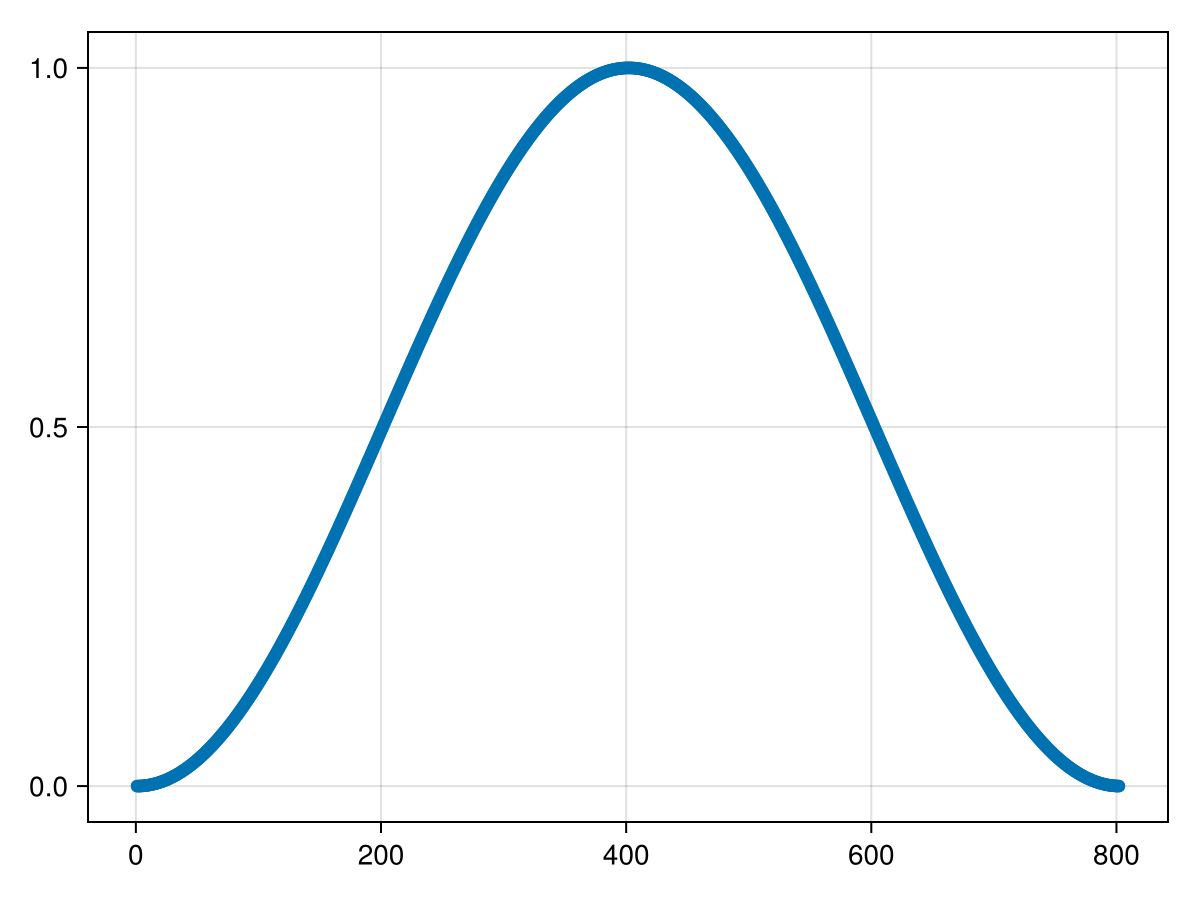

In [19]:
function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

plot(1:802, hann(802))

In [11]:
snap_keys = keys(file["snapshots/t"])
t_idx = 1
key = "500000"
#for key in snap_keys
    solution = file["snapshots/sol/" * key]
    Φ₀ = compute_balanced_basis(grid)
    Φ₊, Φ₋ = compute_wave_bases(grid)
    bc_components = solution[:,:,2:4]
    
    a₀ = sum(bc_components .* conj(Φ₀), dims=3)
    a₊ = sum(bc_components .* conj(Φ₊), dims=3)
    a₋ = sum(bc_components .* conj(Φ₋), dims=3)
    t_idx += 1
#end

2

In [12]:
size(snapshots)

LoadError: UndefVarError: `snapshots` not defined

In [13]:
bc_comp = zeros(512, 512)
w_pos_comp = zeros(512, 512)
w_neg_comp = zeros(512, 512)
ldiv!(bc_comp, grid.rfftplan, deepcopy(a₀[:,:,1]))
ldiv!(w_pos_comp, grid.rfftplan, deepcopy(a₊[:,:,1]))
ldiv!(w_neg_comp, grid.rfftplan, deepcopy(a₋[:,:,1]))

512×512 Matrix{Float64}:
 -0.0180683   -0.0186213   -0.0192739   …  -0.0170708   -0.0175718
 -0.02299     -0.0237824   -0.0246247      -0.0213852   -0.0222083
 -0.027663    -0.0287179   -0.029773       -0.0254251   -0.0265784
 -0.0320391   -0.0333756   -0.0346677      -0.0291619   -0.0306423
 -0.0360766   -0.0377082   -0.0392591      -0.0325678   -0.0343653
 -0.0397334   -0.0416675   -0.0434931   …  -0.0356069   -0.0377103
 -0.0429669   -0.0452034   -0.0473106      -0.0382382   -0.0406383
 -0.0457408   -0.0482705   -0.0506545      -0.0404287   -0.0431172
 -0.0480333   -0.0508371   -0.0534807      -0.0421632   -0.045131
 -0.0498402   -0.0528904   -0.0557655      -0.0434456   -0.046681
 -0.0511688   -0.0544337   -0.0575064   …  -0.0442888   -0.0477772
 -0.0520273   -0.0554767   -0.0587133      -0.0447003   -0.0484263
 -0.0524161   -0.0560259   -0.0593991      -0.0446752   -0.0486244
  ⋮                                     ⋱   ⋮           
  0.0336669    0.0347279    0.0355199   …   0.030

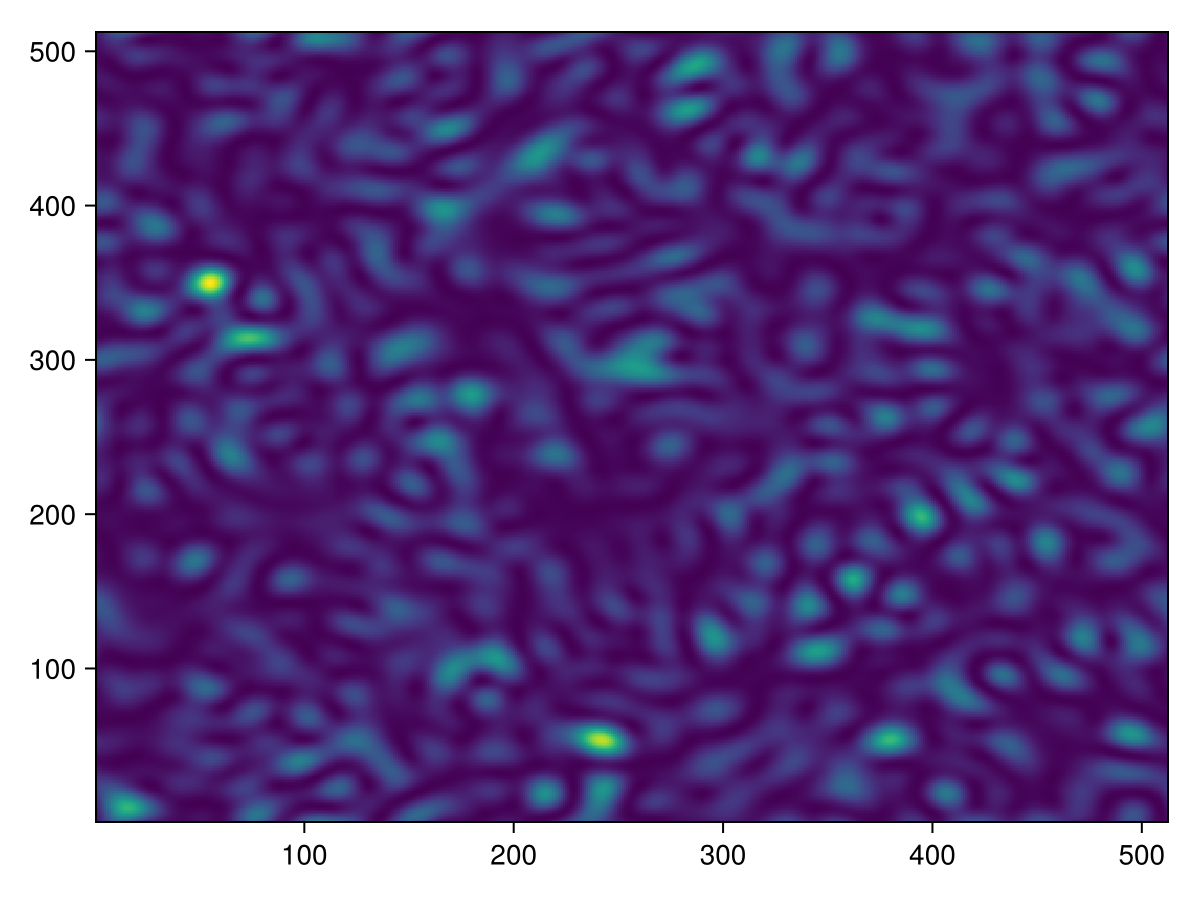

In [14]:
heatmap(w_neg_comp.^2 + w_pos_comp.^2)

In [15]:
Etr, Egr, Ewr = total_energy_spectrum(solution, grid)

((0.0:0.16634050880626222:85.0, [0.0; 74175.86336168974; … ; 0.0; 0.0;;]), (0.0:0.16634050880626222:85.0, [3.358343186781363e-27; 61193.2748336502; … ; 0.0; 0.0;;]), (0.0:0.16634050880626222:85.0, [80463.16787864662; 84597.31668555489; … ; 0.0; 0.0;;]))

In [16]:
ρt, Etρ = Etr
ρg, Egρ = Egr
ρw, Ewρ = Ewr

(0.0:0.16634050880626222:85.0, [80463.16787864662; 84597.31668555489; … ; 0.0; 0.0;;])

In [17]:
dρ = ρt[2] - ρt[1]
Et = sum(Etρ) * dρ
Eg = sum(Egρ) * dρ
Ew = sum(Ewρ) * dρ

6.494898749078805e6

In [18]:
uth = -1im * grid.l  .* grid.invKrsq .* solution[:,:,1]
vth =  1im * grid.kr .* grid.invKrsq .* solution[:,:,1]
ut = irfft(uth, grid.nx)
vt = irfft(vth, grid.nx)

Et_test = sum(ut.^2 + vt.^2) * grid.dx^2
println(Et_test)

Et_parseval = my_parsevalsum2(sqrt.(grid.invKrsq) .* solution[:,:,1], grid)
println(Et_parseval)

0.5874937581432146


LoadError: UndefVarError: `my_parsevalsum2` not defined

In [19]:
uch = solution[:,:,2]
vch = solution[:,:,3]
uc = irfft(uch, grid.nx)
vc = irfft(vch, grid.nx)

Ec_test = sum(uc.^2 + vc.^2) * grid.dx^2
println(Ec_test)

Ec_parseval = parsevalsum2(solution[:,:,2], grid) + parsevalsum2(solution[:,:,3], grid)
println(Ec_parseval)

0.4844076724621415
0.4897719123144906


In [20]:
Gh, Wh = decompose_balanced_wave(solution, grid)
#Gh = solution[:,:,2:4]
Gh = solution[:,:,2:4]
ugh = deepcopy(Gh[:,:,1])
vgh = deepcopy(Gh[:,:,2])
pgh = deepcopy(Gh[:,:,3])
ug = irfft(deepcopy(ugh), grid.nx)
vg = irfft(deepcopy(vgh), grid.nx)
pg = irfft(pgh, grid.nx)

ughh = fft(ug)
vghh = fft(vg)
pghh = fft(pg)

Eg_test = sum(ug.^2 + vg.^2 + pg.^2) * grid.dx^2
println("Total energy (grid space): ", Eg_test)
Eg_test1 = sum(abs2.(ughh) + abs2.(vghh) + abs2.(pghh))
println("Total energy (unnormalized wavenumber space): ", Eg_test1)

Eg_parseval = parsevalsum2(Gh[:,:,1], grid) + parsevalsum2(Gh[:,:,2], grid) + parsevalsum2(Gh[:,:,3], grid)
println("Total energy (GF parseval): ", Eg_parseval)

#myEg_parseval = my_parsevalsum2(Gh[:,:,1], grid) + my_parsevalsum2(Gh[:,:,2], grid) + my_parsevalsum2(Gh[:,:,3], grid)
#println("Total energy (my parseval): ", myEg_parseval)

Eg_parseval = parsevalsum2(ughh, grid) + parsevalsum2(vghh, grid) + parsevalsum2(pghh, grid)
println("Total energy (GF parseval (fft)): ", Eg_parseval)

#myEg_parseval = my_parsevalsum2(ughh, grid) + my_parsevalsum2(vghh, grid) + my_parsevalsum2(pghh, grid)
#println("Total energy (my parseval (fft)): ", myEg_parseval)

Egh = abs2.(ugh) + abs2.(vgh) + abs2.(pgh)
ρ, Egρ = FourierFlows.radialspectrum(Egh, grid, refinement = 1)
dρ = ρ[2] - ρ[1]
E_total = sum(Egρ)
println("Radial spectrum sum (GF): ", E_total)

myr, myEgr = isospectrum(Egh, grid, refinement = 1)
dr = myr[2] - myr[1]
myE_total = sum(myEgr)
println("Radial spectrum sum (me): ", myE_total)

Total energy (grid space): 0.6793756379914531
Total energy (unnormalized wavenumber space): 1.3139764059845817e8
Total energy (GF parseval): 0.6876054549049385
Total energy (GF parseval (fft)): 0.6793756379914531
Radial spectrum sum (GF): 8.93911762366584e7


LoadError: UndefVarError: `isospectrum` not defined

In [17]:
fig = Figure(size=(800, 500))
ax = Axis(fig[1,1], xscale=log10, yscale=log10)
lines!(ax, myr, myEgr .+ 1e-8)

fig

LoadError: UndefVarError: `myr` not defined

In [18]:
ζt = irfft(solution[:,:,1], grid.nx)
ζh = fft(ζt)
f = Figure()
ax = Axis(f[1,1], cscale=log10)
#heatmap(ζt)
ax, hm, heatmap!(ax, fftshift(grid.k[:]), fftshift(grid.l[:]), fftshift((abs2.(ζh))))
Colorbar(f[1,2], 
f

LoadError: MethodError: no method matching initialize_block!(::Axis; cscale::typeof(log10))

[0mClosest candidates are:
[0m  initialize_block!(::Axis; palette)[91m got unsupported keyword argument "cscale"[39m
[0m[90m   @[39m [35mMakie[39m [90m/ext3/pkgs/packages/Makie/QGPt0/src/makielayout/blocks/[39m[90m[4maxis.jl:160[24m[39m
[0m  initialize_block!([91m::Box[39m)[91m got unsupported keyword argument "cscale"[39m
[0m[90m   @[39m [35mMakie[39m [90m/ext3/pkgs/packages/Makie/QGPt0/src/makielayout/blocks/[39m[90m[4mbox.jl:1[24m[39m
[0m  initialize_block!([91m::Button[39m)[91m got unsupported keyword argument "cscale"[39m
[0m[90m   @[39m [35mMakie[39m [90m/ext3/pkgs/packages/Makie/QGPt0/src/makielayout/blocks/[39m[90m[4mbutton.jl:1[24m[39m
[0m  ...


In [19]:
fftshift(grid.k[:])

LoadError: UndefVarError: `fftshift` not defined

In [8]:
function isospectrum(fh, grid; refinement = 1)
    nmax = (Int(min(grid.nk, grid.nl)/2) - 1) * refinement
    ρ = ((0:nmax+1) .- 0.5) / min(grid.Lx, grid.Ly) * (2*pi) / refinement
    Fρ = zeros(nmax+2,1)
    K = nothing
    scaling = nothing
    if size(fh, 1) == grid.nkr
        K = sqrt.(grid.Krsq)
        scaling = ones(size(grid.Krsq))
        scaling[2:grid.nkr-1,:] .= 2.
    else
        K = sqrt.(grid.Ksq)
        scaling = ones(size(grid.Ksq))
    end
    for i=2:nmax+2
        mask = @. (ρ[i-1] < K) & (K <= ρ[i])
        Fρ[i] = sum(fh .* mask .* scaling) # * grid.dx * grid.dy / grid.nx / grid.ny
    end
    return ρ[2:end], Fρ[2:end]
end

function isospectrum_helper(fh, grid; refinement = 1)
    #nmax = (Int(min(grid.nk, grid.nl)/2) - 1) * refinement
    nmax = Int(ceil(maximum(sqrt.(grid.Krsq)) * min(grid.Lx, grid.Ly) / (2*pi)))
    ρ = ((0:nmax+1) .- 0.5) / min(grid.Lx, grid.Ly) * (2*pi) / refinement
    Fρ = zeros(grid.nk, grid.nl)
    K = nothing
    scaling = nothing
    if size(fh, 1) == grid.nkr
        K = sqrt.(grid.Krsq)
        scaling = ones(size(grid.Krsq))
        scaling[2:grid.nkr-1,:] .= 2.
    else
        K = sqrt.(grid.Ksq)
        scaling = ones(size(grid.Ksq))
    end
    for i=2:nmax+2
        mask = @. (ρ[i-1] < K) & (K <= ρ[i])
        Fρ .+= fh .* mask .* scaling
    end
    return Fρ
end

isospectrum_helper (generic function with 1 method)

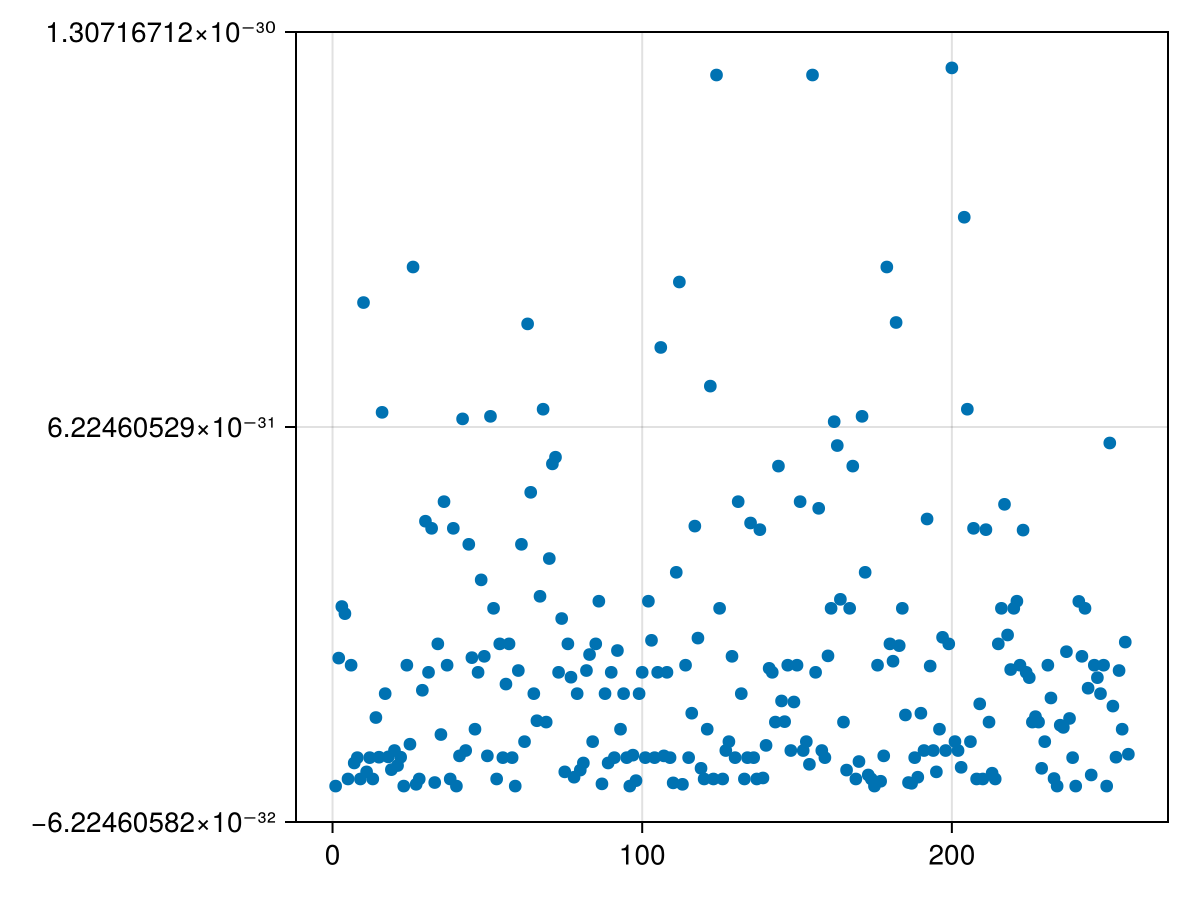

┌ Warning: No strict ticks found
└ @ PlotUtils /ext3/pkgs/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /ext3/pkgs/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [21]:
#field = solution[:,:,1]
field = randn(grid.nkr, grid.nl) + 1im*randn(grid.nkr, grid.nl)
field[1,grid.nl:-1:grid.nl-grid.nkr+3] = conj.(field[1,2:grid.nkr-1])
field[1, 1] = real(field[1,1])
field[:,grid.nkr] .= 0
field[:,grid.nl] .= 0
field[grid.nkr,:] .= 0
my_field = fft(ifft(field))
my_rfield = rfft(irfft(field, grid.nx))
my_rfield2 = rfft(irfft(my_rfield, grid.nx))
plot(abs2.(field[:,1] - my_rfield[:,1]))
current_figure()

In [4]:
function isospectrum_test(grid; refinement = 1)
    #nmax = (Int(min(grid.nk, grid.nl)/2) - 1) * refinement
    nmax = Int(ceil(maximum(sqrt.(grid.Ksq)) * min(grid.Lx, grid.Ly) / (2*pi)))
    println(nmax)
    ρ = ((0:nmax+1) .- 0.5) / min(grid.Lx, grid.Ly) * (2*pi) / refinement
    Fρ = zeros(nmax+2,1)
    K = nothing
    scaling = nothing
    #if size(fh, 1) == grid.nkr
    #    K = sqrt.(grid.Krsq)
    #    scaling = ones(size(grid.Krsq))
    #    scaling[2:grid.nkr-1,:] .= 2.
    #else
    K = sqrt.(grid.Ksq)
    scaling = ones(size(grid.Ksq))
    #end
    mask = zeros(grid.nk, grid.nl)
    for i=2:nmax+2
        @. mask += (ρ[i-1] < K) & (K <= ρ[i])
    end
    return mask
end

isospectrum_test (generic function with 1 method)

In [5]:
"""
    fftshift!(dest, src, [dim])

Nonallocating version of [`fftshift`](@ref). Stores the result of the shift of the `src` array into the `dest` array.
"""
function fftshift!(dest, src, dim = 1:ndims(src))
    s = ntuple(d -> d in dim ? div(size(dest,d),2) : 0, Val(ndims(dest)))
    circshift!(dest, src, s)
end

"""
    fftshift(x, [dim])

Circular-shift along the given dimension of a periodic signal `x` centered at
index `1` so it becomes centered at index `N÷2+1`, where `N` is the size of
that dimension.

This can be undone with [`ifftshift`](@ref). For even `N` this is equivalent to
swapping the first and second halves, so `fftshift` and [`ifftshift`](@ref) are
the same.

If `dim` is not given then the signal is shifted along each dimension.

The output of `fftshift` is allocated. If one desires to store the output in a preallocated array, use [`fftshift!`](@ref) instead.
"""
fftshift

fftshift(x, dim = 1:ndims(x)) = fftshift!(similar(x), x, dim)

"""
    ifftshift!(dest, src, [dim])

Nonallocating version of [`ifftshift`](@ref). Stores the result of the shift of the `src` array into the `dest` array.
"""
function ifftshift!(dest, src, dim = 1:ndims(src))
    s = ntuple(d -> d in dim ? -div(size(src,d),2) : 0, Val(ndims(src)))
    circshift!(dest, src, s)
end

"""
    ifftshift(x, [dim])

Circular-shift along the given dimension of a periodic signal `x` centered at
index `N÷2+1` so it becomes centered at index `1`, where `N` is the size of
that dimension.

This undoes the effect of [`fftshift`](@ref). For even `N` this is equivalent to
swapping the first and second halves, so [`fftshift`](@ref) and `ifftshift` are
the same.

If `dim` is not given then the signal is shifted along each dimension.

The output of `ifftshift` is allocated. If one desires to store the output in a preallocated array, use [`ifftshift!`](@ref) instead.
"""
ifftshift

ifftshift(x, dim = 1:ndims(x)) = ifftshift!(similar(x), x, dim)

ifftshift (generic function with 2 methods)

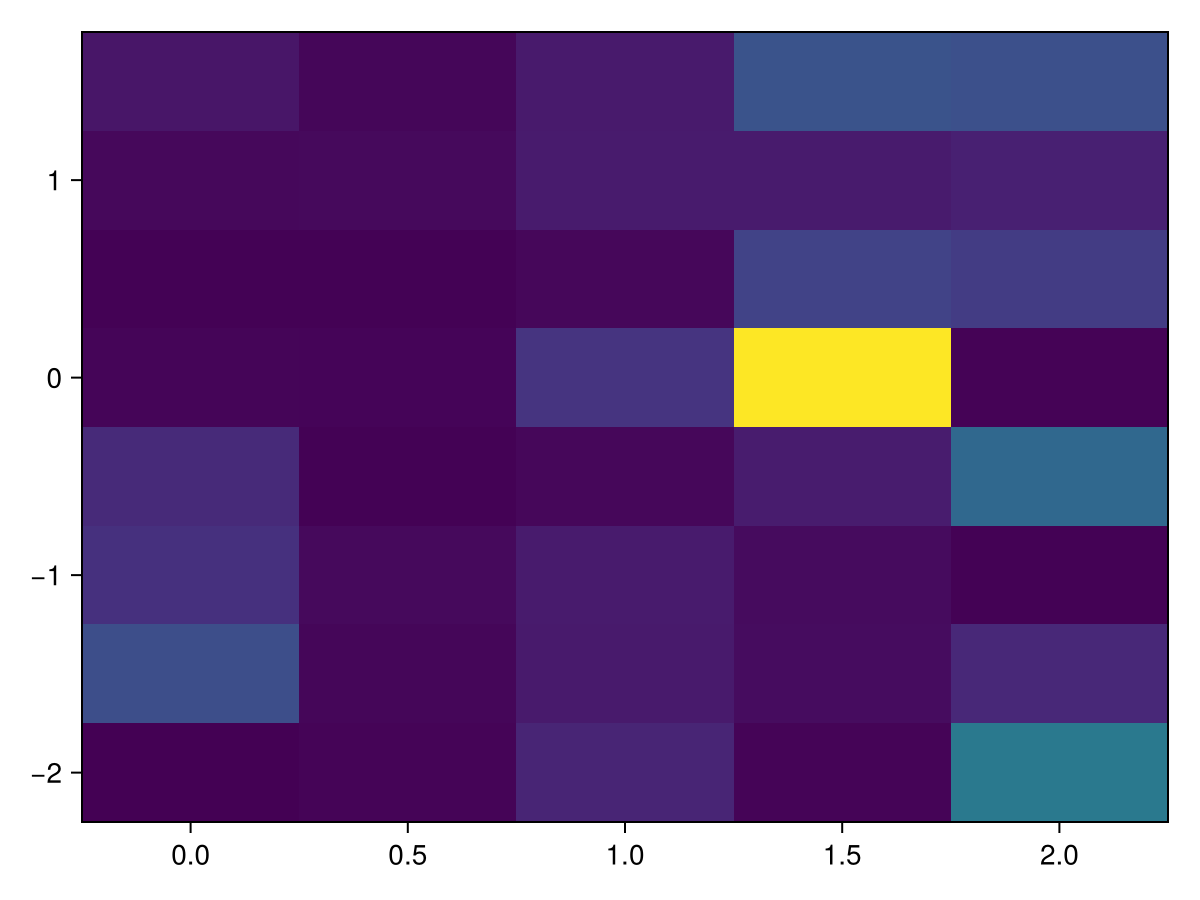

In [6]:
small_grid = TwoDGrid(CPU(); nx=8, Lx=4π, aliased_fraction=0, T=Float64)
field = zeros(Float64, small_grid.nx, small_grid.ny)
A = randn(small_grid.nk, small_grid.nl)
for i=1:small_grid.nk
    for j=1:small_grid.nl
        field += A[i,j]*cos.(small_grid.k[i]*small_grid.x .+ small_grid.l[j]*small_grid.y')
    end
end

heatmap(field)
rfieldh = rfft(field)
fieldh = fft(field)
heatmap(small_grid.kr[:], fftshift(small_grid.l)[:], abs2.(fftshift(rfieldh)))

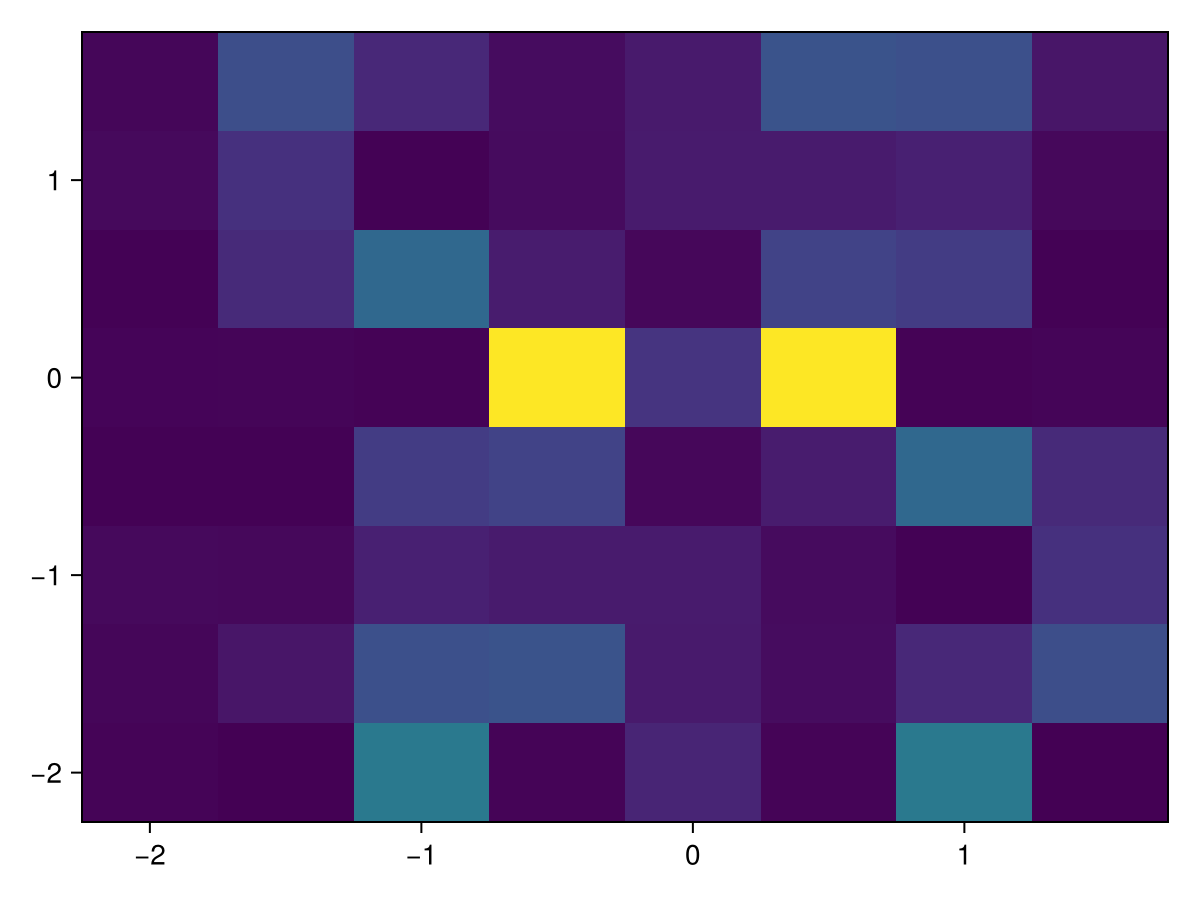

In [7]:
heatmap(fftshift(small_grid.k[:]), fftshift(small_grid.l)[:], abs2.(fftshift(fieldh)))

In [8]:
my_fieldh = zeros(Complex{Float64}, small_grid.nk, small_grid.nl)
my_fieldh[1:small_grid.nkr-1,:] = rfieldh[1:small_grid.nkr-1,:]
my_fieldh[small_grid.nkr:end,1] = conj.(rfieldh[small_grid.nkr:-1:2,1])
my_fieldh[small_grid.nkr:end,2:small_grid.nl] = conj.(rfieldh[small_grid.nkr:-1:2,small_grid.nl:-1:2])

4×7 Matrix{ComplexF64}:
  7.06398+7.25781e-15im   21.0036-0.0im          …   7.06398-7.25781e-15im
 -49.1066+1.70909e-14im  -52.9065+7.32094e-15im     -8.20094-2.44903e-15im
 -82.9149+9.03417e-15im   7.92084-1.77636e-15im      59.7194-5.48146e-15im
 -39.2764+1.08736e-14im   23.3126+2.15508e-16im     -63.6418-1.04426e-14im

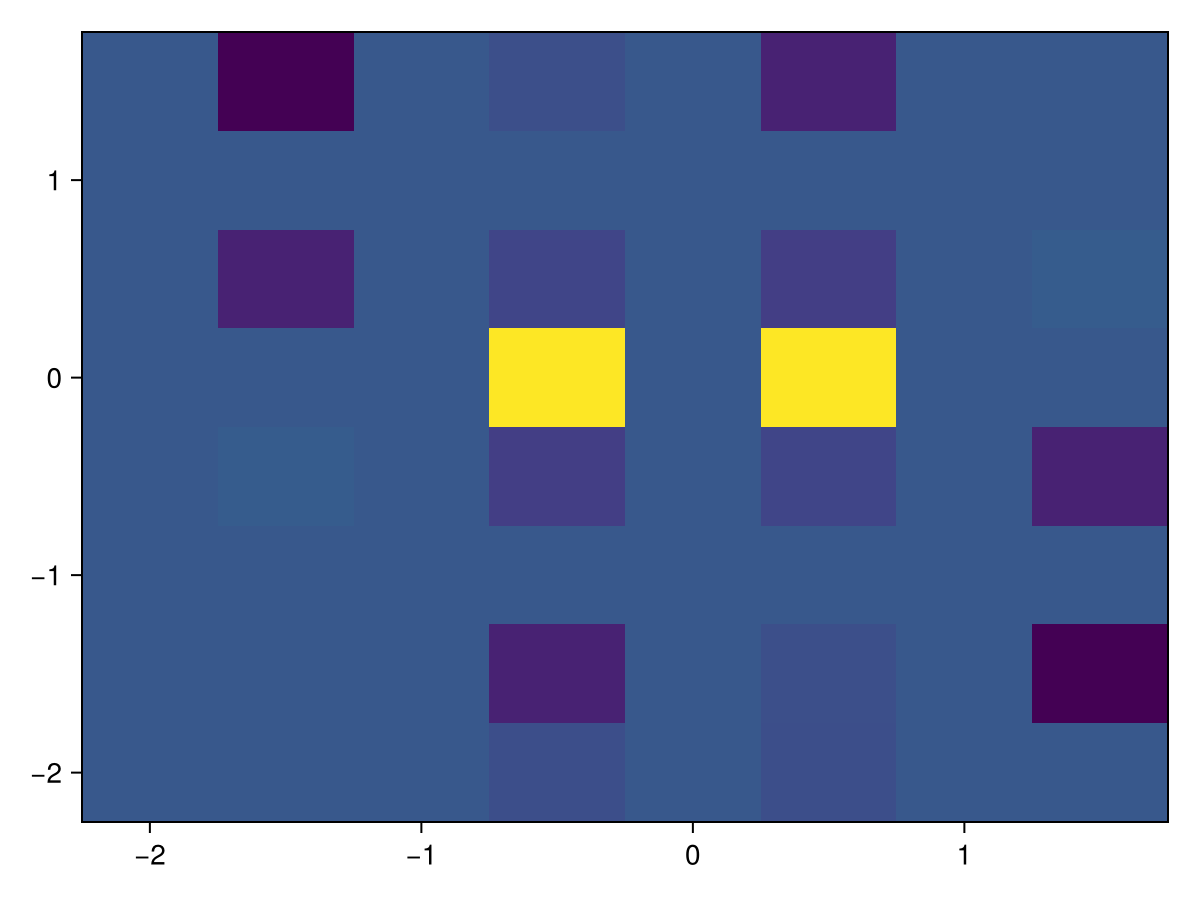

In [9]:
heatmap(fftshift(small_grid.k[:]), fftshift(small_grid.l)[:], abs2.(fftshift(my_fieldh)) - abs2.(fftshift(fieldh)))

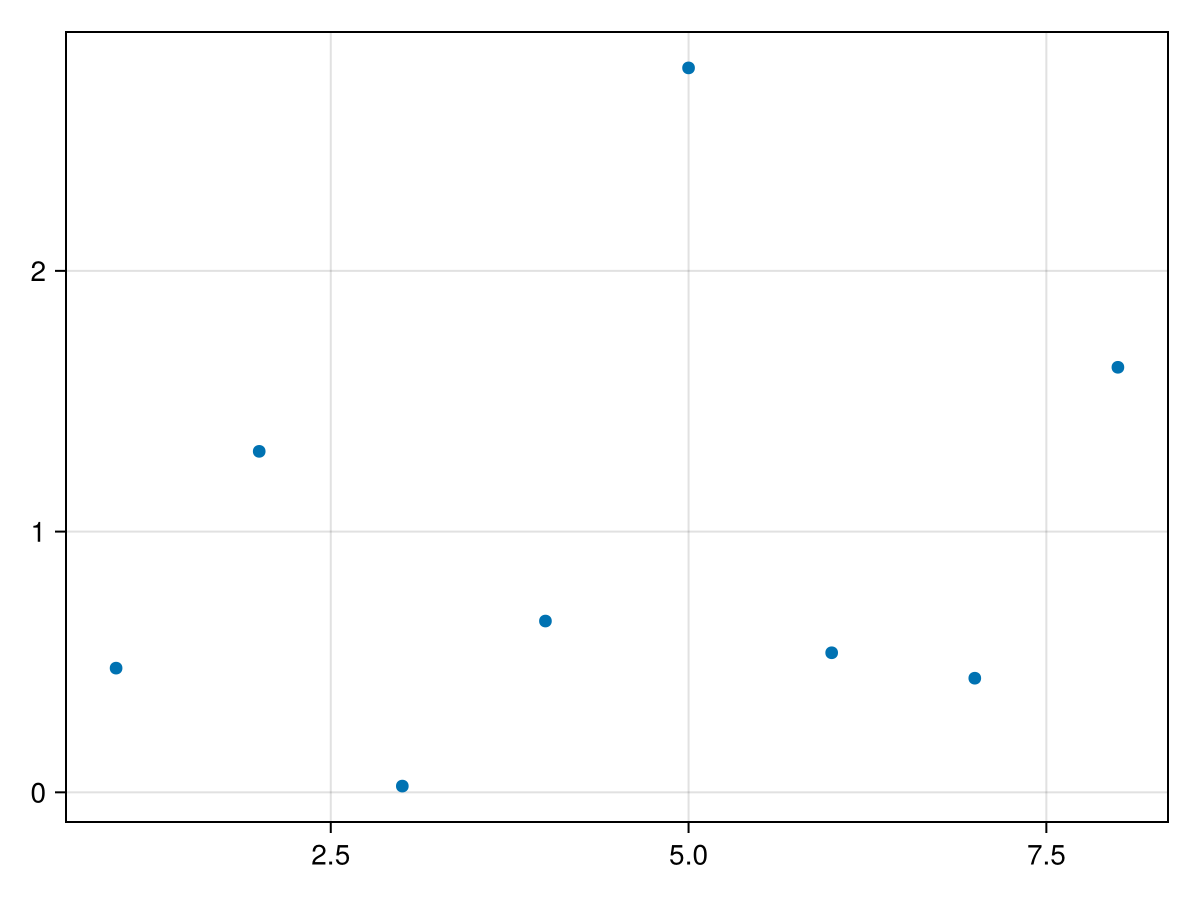

In [28]:
field = randn(small_grid.nkr, small_grid.nl) + 1im*randn(small_grid.nkr, small_grid.nl)
my_field = fft(ifft(field))
sample_field = deepcopy(field)
sample_field[1, :] /= 2
sample_field[end, :] /= 2
my_rfield = rfft(irfft(sample_field, small_grid.nx))
my_rfield2 = rfft(irfft(my_rfield, small_grid.nx))
plot(abs2.(field[1,:] - my_rfield[1,:]))
current_figure()

In [10]:
file = jldopen("/scratch/nad9961/thomasyamada_simulation/44050297/2/ty.jld2", "r")
grid = TwoDGrid(CPU(); nx, Lx, ny, Ly, aliased_fraction=0, T=Float64)
N = length(keys(file["snapshots/t"]))
t = zeros(N)
total_energy = zeros(N)
bt_energy = zeros(N)
bc_energy = zeros(N)
bc_ke_energy = zeros(N)
wave_ke_energy = zeros(N)
wave_energy = zeros(N)
geo_energy = zeros(N)
geo_ke_energy = zeros(N)
balanced_energy = zeros(N)
e_idx = 1
for idx in keys(file["snapshots/t"])
    t[e_idx] = file["snapshots/t/" * idx]
    snapshot = file["snapshots/sol/" * idx]
    bt = snapshot[:, :, 1]
    bc = snapshot[:, :, 2:4]
    Gh, Wh = decompose_balanced_wave(snapshot, grid)
    
    bt_energy[e_idx] = parsevalsum2(sqrt.(grid.invKrsq) .* bt, grid)
    bc_ke_energy[e_idx] = parsevalsum2(bc[:,:,1], grid) + parsevalsum2(bc[:,:,2], grid)
    bc_energy[e_idx] = bc_ke_energy[e_idx] + parsevalsum2(bc[:,:,3], grid)
    
    wave_ke_energy[e_idx] = parsevalsum2(Wh[:,:,1], grid) + parsevalsum2(Wh[:,:,2], grid)
    geo_ke_energy[e_idx]  = parsevalsum2(Gh[:,:,1], grid) + parsevalsum2(Gh[:,:,2], grid)
    wave_energy[e_idx] = wave_ke_energy[e_idx] + parsevalsum2(Wh[:,:,3], grid)
    geo_energy[e_idx]  = geo_ke_energy[e_idx]  + parsevalsum2(Gh[:,:,3], grid)
    
    e_idx += 1
end
total_energy = bc_energy + bt_energy
balanced_energy = bt_energy + geo_energy
close(file)

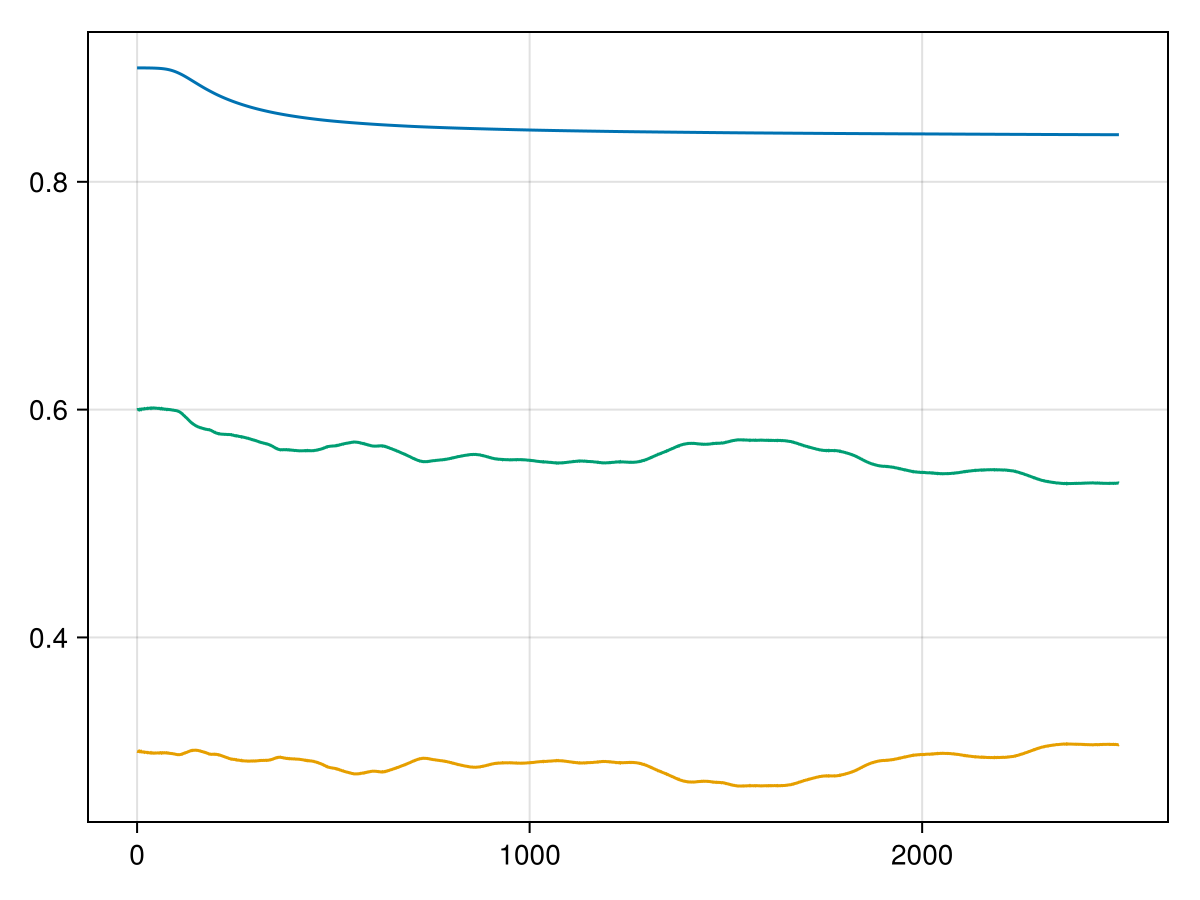

In [30]:
lines(t[:], total_energy[:])
lines!(t[:], bt_energy[:])
lines!(t[:], bc_energy[:])

current_figure()

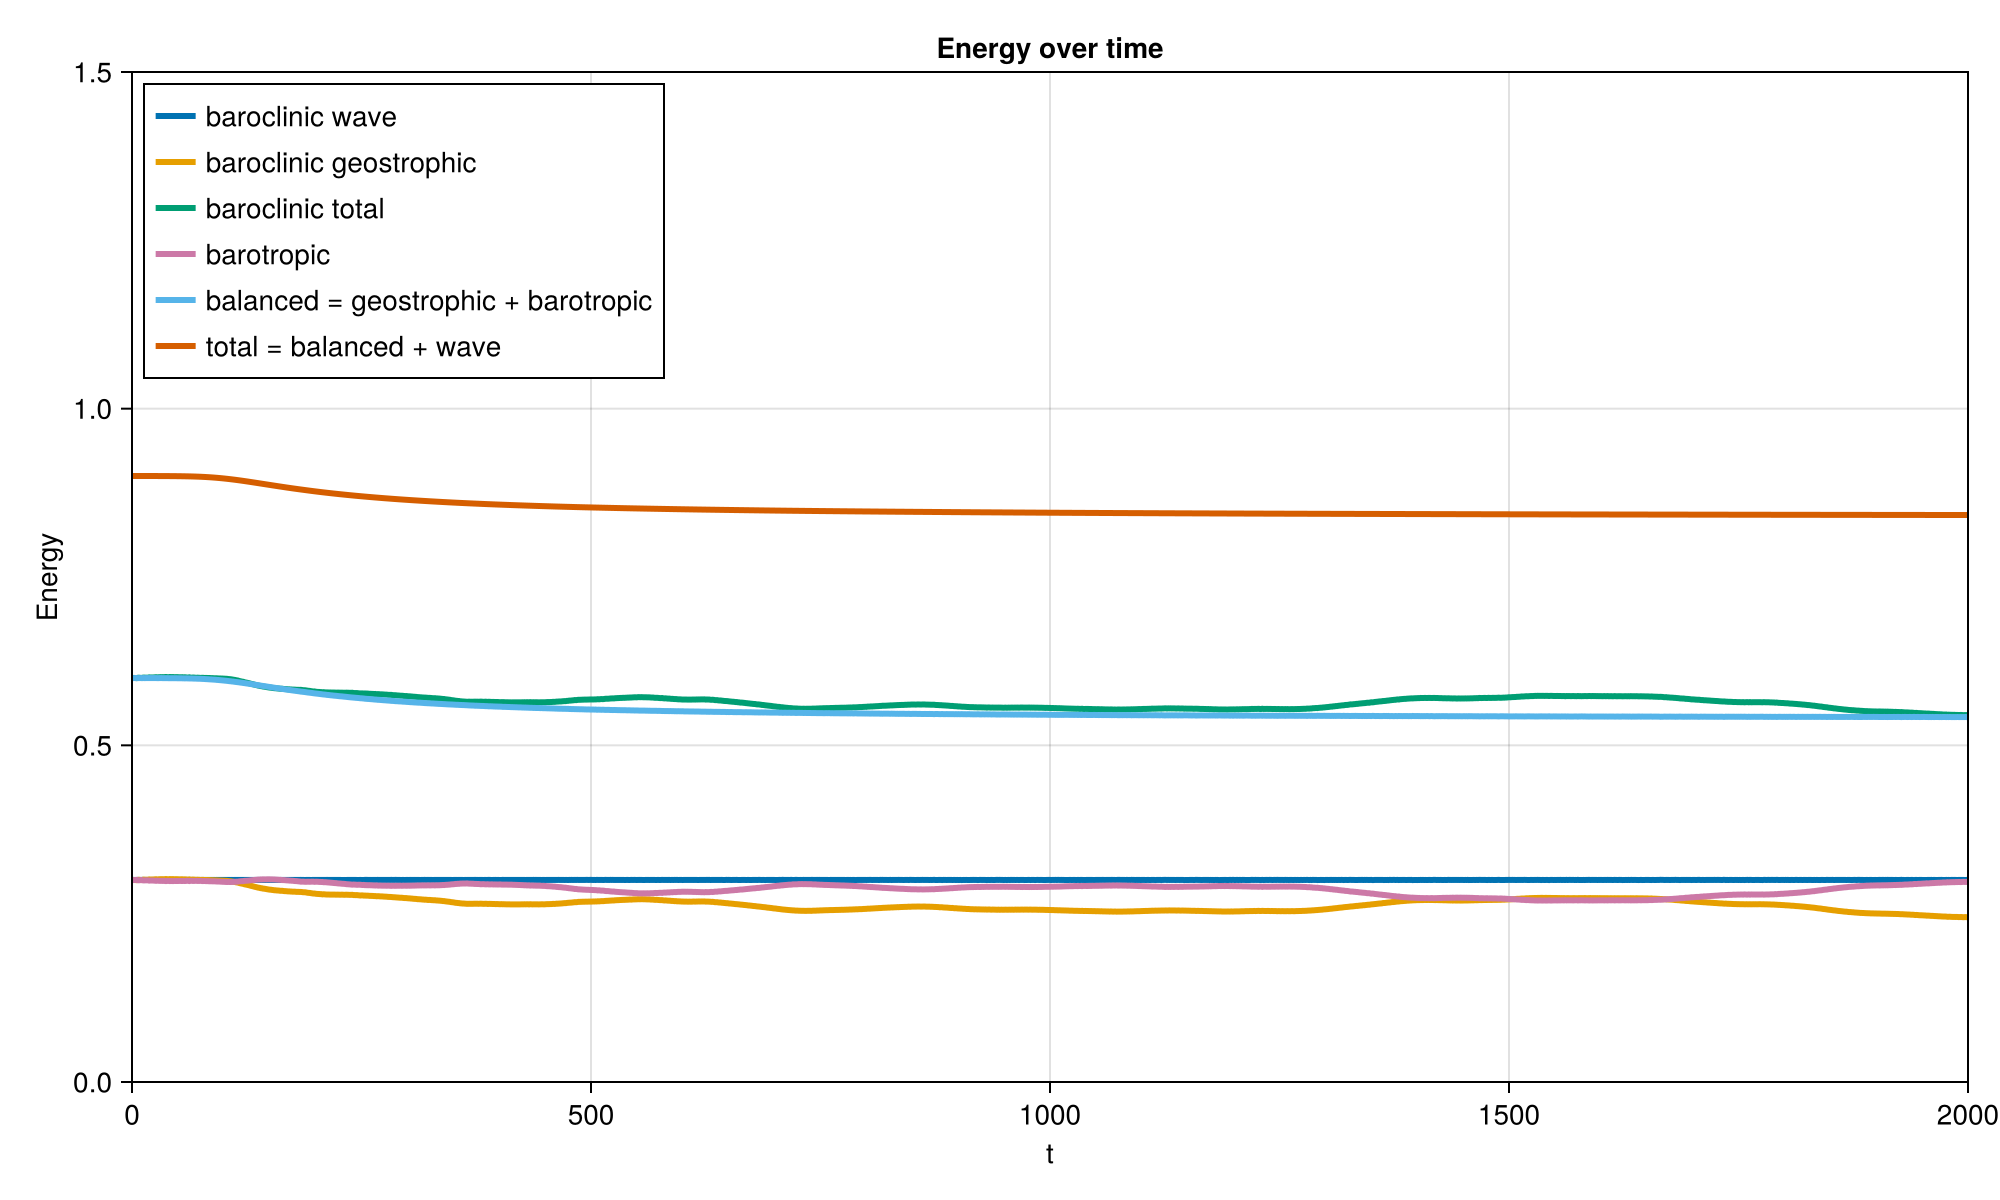

In [31]:
f = Figure(size=(1000, 600))
ax = Axis(f[1,1], xlabel="t", ylabel="Energy", title="Energy over time", limits=((0, 2000.), (0, 1.5)))


balanced_energy = bt_energy + geo_energy
lines!(ax, t[:], wave_energy, label="baroclinic wave"; linewidth=3)
lines!(ax, t[:], geo_energy, label="baroclinic geostrophic"; linewidth=3)
lines!(ax, t[:], bc_energy, label="baroclinic total"; linewidth=3)
lines!(ax, t[:], bt_energy, label="barotropic"; linewidth=3)
lines!(ax, t[:], balanced_energy, label="balanced = geostrophic + barotropic"; linewidth=3)
lines!(ax, t[:], total_energy, label="total = balanced + wave"; linewidth=3)

axislegend(ax, position = :lt)
f

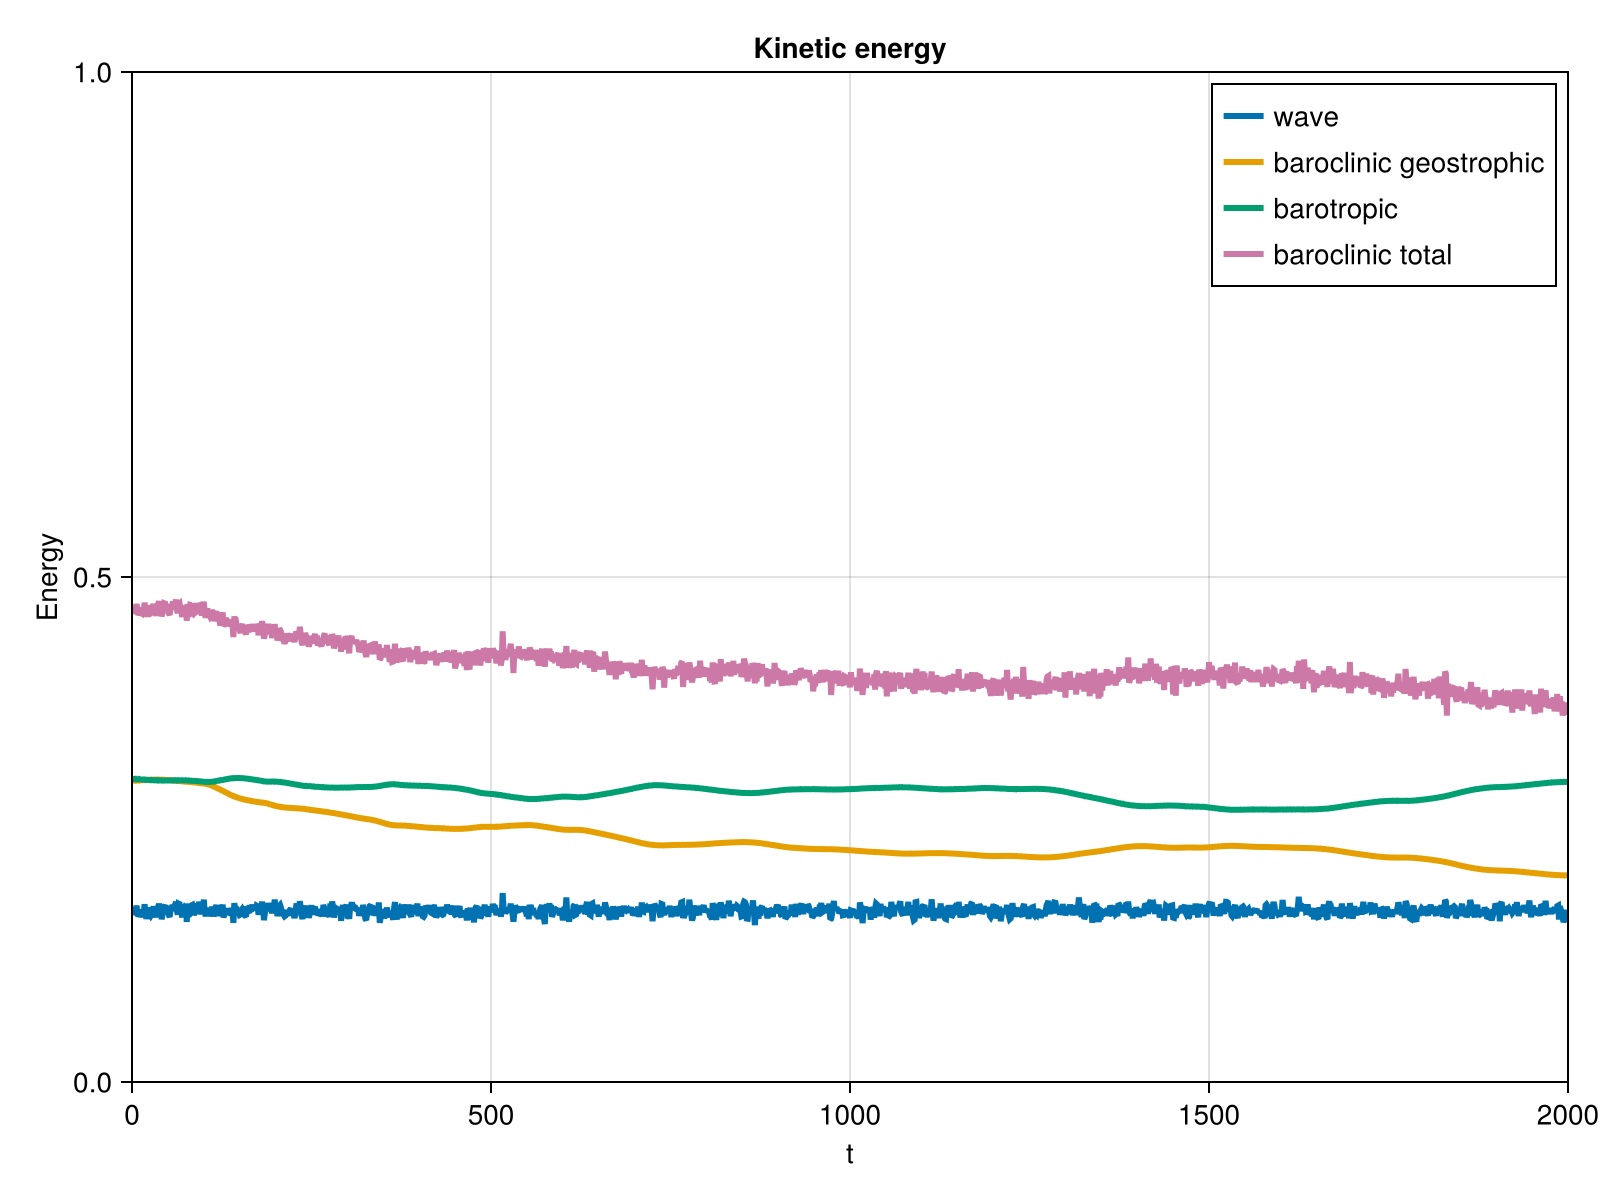

In [32]:
f = Figure(size=(800, 600))
ax = Axis(f[1,1], xlabel="t", ylabel="Energy", title="Kinetic energy", limits=((0, 2000.), (0, 1)))

balanced_energy = bt_energy + geo_energy
lines!(ax, t[:], wave_ke_energy, label="wave"; linewidth=3)
lines!(ax, t[:], geo_ke_energy, label="baroclinic geostrophic"; linewidth=3)
lines!(ax, t[:], bt_energy, label="barotropic"; linewidth=3)
lines!(ax, t[:], bc_ke_energy, label="baroclinic total"; linewidth=3)

axislegend(ax)
f

In [33]:
t = zeros(N)
total_energy = zeros(N, 1)
t_idx = 1
for idx in keys(file["snapshots/t"])
    snapshot = file["snapshots/sol/" * idx]
    bt = snapshot[:, :, 1]
    t[t_idx] = file["snapshots/t/" * idx]
    bt_energy[t_idx] = parsevalsum2(sqrt.(grid.invKrsq) .* bt, grid)
    total_energy[t_idx] = bc_energy[t_idx] + bt_energy[t_idx]
    t_idx += 1
end

LoadError: ArgumentError: file is closed

In [34]:
close(file)

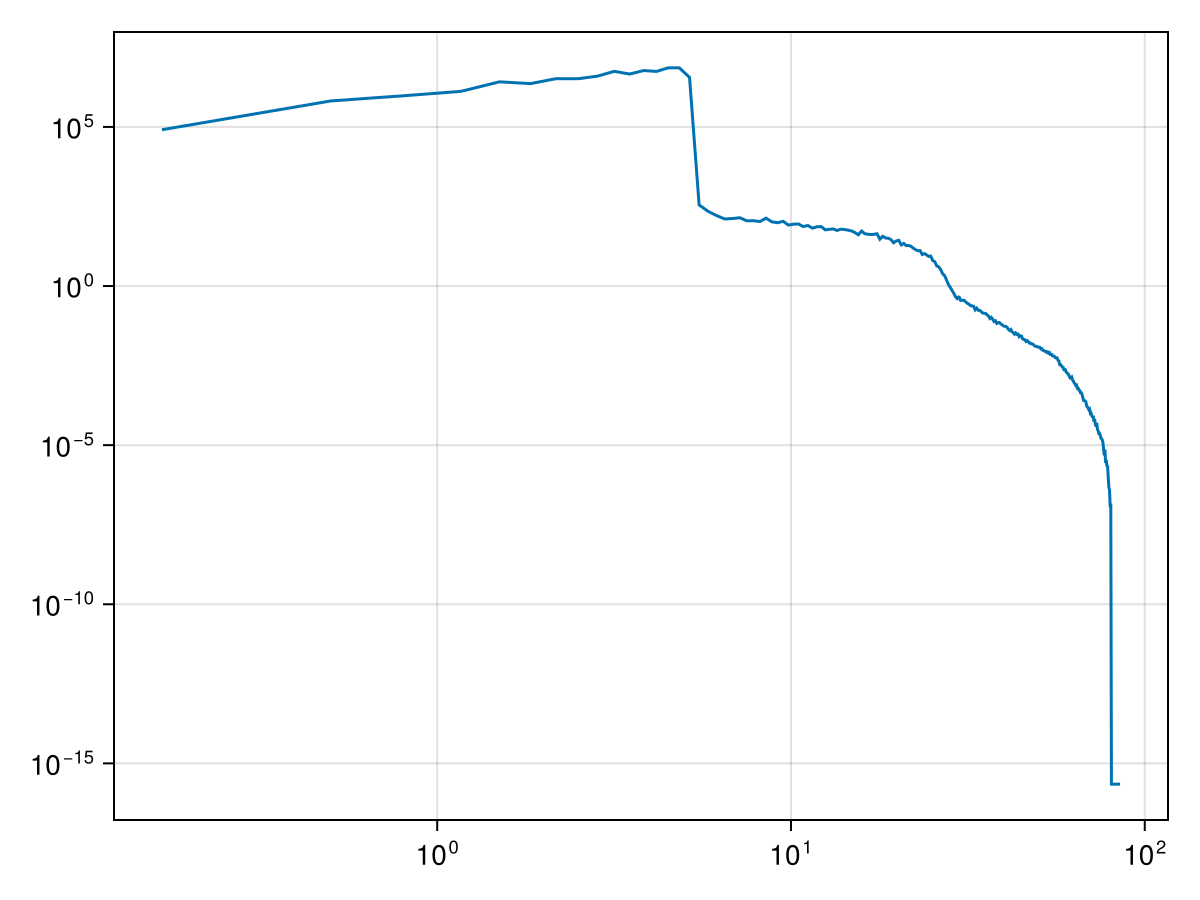

In [35]:
file = jldopen("/scratch/nad9961/thomasyamada_simulation/44050297/2/ty.jld2", "r")
frame = "45000"
t_ = file["snapshots/t/" * frame]
sol_ = file["snapshots/sol/" * frame]
Gh, Wh = decompose_balanced_wave(sol_, grid)
Ewh = sum(abs2, Wh, dims=3)
close(file)
r, Egr = isospectrum(Ewh, grid)
f = Figure()
ax = Axis(f[1,1], xscale=log10, yscale=log10)
lines!(ax, r, Egr .+ eps())

f

In [47]:
file = jldopen("/scratch/nad9961/thomasyamada_simulation/44050297/2/ty.jld2", "r")
frames = keys(file["snapshots/t"])
t = zeros(length(frames))
t_spinup = 1500.
t_idx = 1
for frame in frames
    if file["snapshots/t/" * frame] >= t_spinup
        println("Ended at frame " * frame)
        break
    end
    t_idx += 1
end

k_factor = 5
k_filter = (k_factor - 0.05)^2 .<= grid.Krsq .<= (k_factor + 0.05)^2
snapshots = zeros(Float64, length(t) - t_idx + 1, length(grid.kr)-1)
println(size(snapshots))
t_idx = 1
snap_idx = 1
for frame in frames
    t[t_idx] = file["snapshots/t/" * frame]
    if t[t_idx] >= t_spinup
        snapshot = file["snapshots/sol/" * frame]
        normalized_fft = rfft(irfft(snapshot, grid.nx, (1,2)), (1,2))
        Gh, Wh = decompose_balanced_wave(normalized_fft, grid)
        KEWh = abs2.(Wh[:,:, 1]) + abs2.(Wh[:,:, 2])
        uWh = abs2.(Wh[:,:,1])
        #E = abs2.(sqrt.(grid.invKrsq) .* snapshot[:,:,1]) + abs2.(snapshot[:,:,2]) + abs2.(snapshot[:,:,3]) + abs2.(snapshot[:,:,4])
        ρ, uWr = isospectrum(uWh, grid)
        snapshots[snap_idx, :] = uWr
        snap_idx += 1
    end
    t_idx += 1
end
close(file)

Ended at frame 300000
(802, 256)


In [63]:
fftshift(snapshots[:,1])

802-element Vector{Float64}:
 73465.05008996582
 18196.89503254359
 34477.22037435425
 63113.2835604013
   697.866845703959
 71504.21284822228
 20860.82593747664
 31996.90071117523
 65794.50761433117
   298.43093873114645
 70395.49083822501
 23672.474671883137
 29423.92631831967
     ⋮
 57413.37794442461
  2809.6549315494226
 75518.22485986647
 14239.977561889684
 39348.805078940546
 59750.65844692386
  1979.1926990683412
 74027.68776959054
 16283.807152935593
 36992.63442103328
 61779.01712428135
  1170.3203883947313

In [49]:
hann(802)

ρ, Er = isospectrum(test_snapshot, grid)

LoadError: UndefVarError: `test_snapshot` not defined

In [65]:
results = abs.(fft(hann(802) .* snapshots, 1))

802×256 Matrix{Float64}:
    1.52652e7      1.14587e8      1.56737e8  …  2.76966e-24  2.7436e-24
    7.63416e6      5.72965e7      7.8437e7      1.37809e-24  1.35974e-24
 2112.61       11539.9            1.60211e5     1.81616e-26  1.78539e-26
 2765.87       17403.5        18565.7           1.63845e-26  1.16248e-26
 1462.7         5954.12        9234.62          8.83969e-27  4.41291e-27
 1282.76        3066.3         7571.43       …  1.35705e-26  5.92512e-27
  382.507       9074.81       18503.4           4.03499e-27  7.44941e-27
 2901.46        5774.09       20020.4           6.53573e-27  4.41358e-27
 7520.38        8559.69       28963.1           2.02447e-27  4.91085e-27
 6861.33        9730.64        2919.23          6.16636e-27  4.93924e-27
 3620.48        6945.16        3102.72       …  1.15678e-26  7.16259e-27
  314.712       9965.53        6435.16          9.09307e-27  3.39496e-27
 1286.8         4067.66        5568.93          2.3329e-27   7.14492e-27
    ⋮                      

In [66]:
using AbstractFFTs
my_ts = t[end-802+1:end]
ωs = AbstractFFTs.fftfreq(802, my_ts[2] - my_ts[1])
#ωs = fftfreq(802, 1)
nmax = (Int(min(grid.nk, grid.nl)/2) - 1)
ρ = ((0:nmax+1) .- 0.5) / min(grid.Lx, grid.Ly) * (2*pi)
ρ = ρ[2:end]
maximum(ωs)

0.6234413965223365

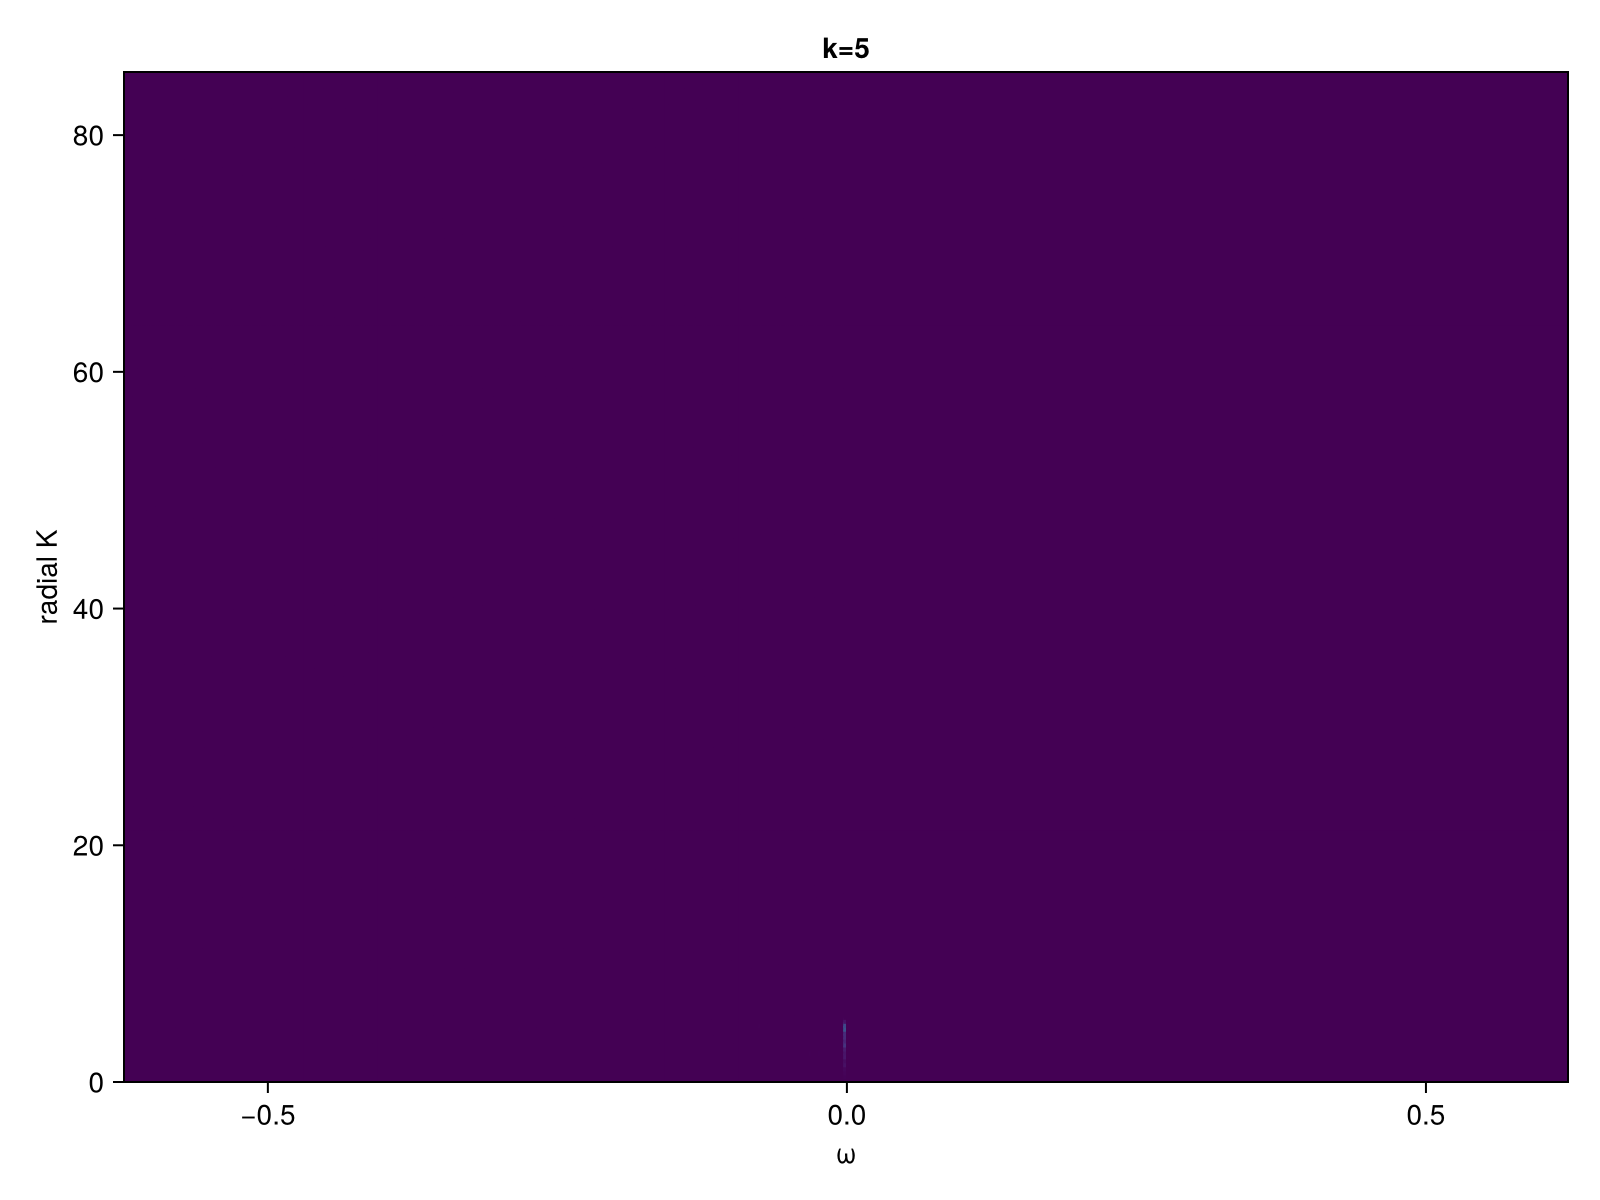

In [76]:
f = Figure(size=(800, 600))
ax = Axis(f[1,1], xlabel="ω", ylabel="radial K", title="k=5")
heatmap!(ax, ωs, ρ, abs2.(results))
#lines!(ax, fftshift(ωs), fftshift(abs.(results[:,1])))
#lines!(ax, sqrt.(ρ.^2 .+ 1)/100., ρ)
f

In [101]:
fftshift(ωs)

-0.6250000000136424:0.003109452736386281:0.6218905472772562

In [7]:
t_spinup = 1500.
k_filter = (sqrt(4.99) .< grid.Krsq .< sqrt(5.01))
println("Number of waves: ", sum(k_filter))
snapshots = zeros(Float64, 802)
idx = 1
for frame in frames
    time = file["snapshots/t/" * frame]
    if time >= t_spinup
        snapshot = file["snapshots/sol/" * frame]
        normalized_fft = rfft(irfft(snapshot, grid.nx, (1,2)), (1,2))
        Gh, Wh = decompose_balanced_wave(normalized_fft, grid)
        uWh = sum(abs2.(Wh[k_filter, 1]))
        snapshots[idx] = uWh
        idx += 1
    end
end

Number of waves: 0


LoadError: InterruptException:

In [87]:
test_snapshot = file["snapshots/sol/" * "500"]
test_snapshot[k_filter, 3]

4-element Vector{ComplexF64}:
  -63.0602401165881 + 121.66150422803337im
 158.49331982594694 + 41.24417647379097im
  77.85654055401005 + 98.68434196505993im
 14.313961101343683 + 3.327239341216198im

In [15]:
using AbstractFFTs
k_values = 1:10
my_results = zeros(802, 10)
k_idx = 1
for k_idx=1:10
    println(k_idx)
    k_value = k_values[k_idx]
    k_filter = (k_value - 0.5)^2 .< grid.Krsq .< (k_value + 0.5)^2
    filter_size = sum(k_filter)
    my_snaps = zeros(802, filter_size)
    snap_idx = 1
    for frame in frames
        time = file["snapshots/t/" * frame]
        if time >= t_spinup
            snapshot = file["snapshots/sol/" * frame]
            normalized_fft = rfft(irfft(snapshot, grid.nx, (1,2)), (1,2))
            Gh, Wh = decompose_balanced_wave(normalized_fft, grid)
            
            KEWh = abs2.(Wh[k_filter, 1]) + abs2.(Wh[k_filter, 2])
            my_snaps[snap_idx,:] = KEWh
            snap_idx += 1
        end
    end
    my_results[:,k_idx] = sum(abs.(fft(hann(802) .* my_snaps, 1)), dims=2)
    #my_results[1,k_idx] = results[1]
    #my_results[2:end,k_idx] = results[1:401] + results[402:end]
end

1
2
3
4
5
6
7
8
9
10


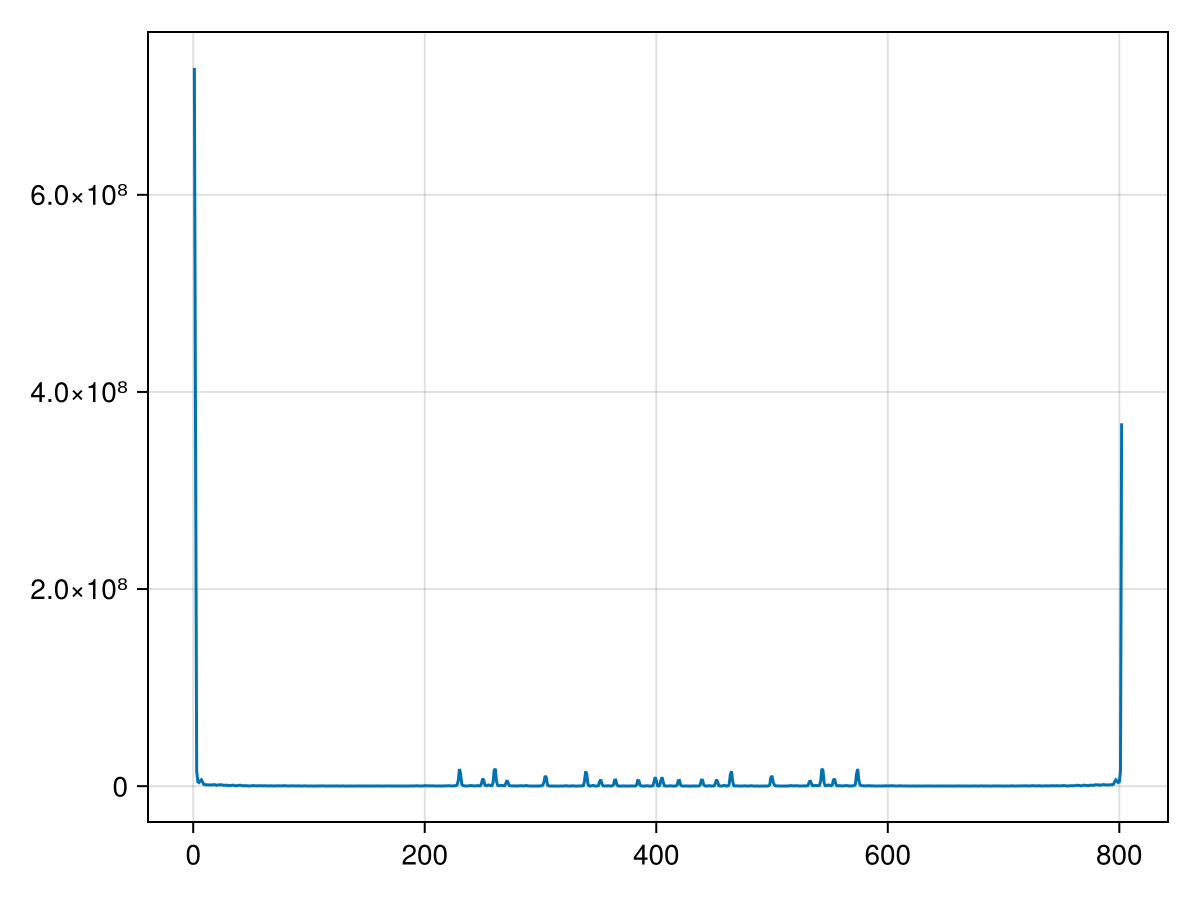

In [19]:
lines(my_results[:,1])

In [ ]:
f = Figure()
ax = Axis(f[1,1], xscale=log10, yscale=log10)

for i=1:10
    lines!(ax, my_results[:,i], label=("k="*string(i)))
end
axislegend(ax)
f

In [108]:
k_filter = (4.99^2 .< grid.Krsq .< 5.01^2)
println("Number of waves: ", sum(k_filter))

Number of waves: 7


In [110]:
grid.Krsq[6, 6]

5.5555555555555545

In [5]:
using AbstractFFTs
using Printf
using JLD2

In [6]:
total_frames = 0

file_list = 50:100
for i=file_list
    file = jldopen(@sprintf("../data/thomasyamada_data/long-run/ty.jld2.%08d.jld2", i))
    frames = keys(file["snapshots/t"])
    total_frames += length(frames)
    close(file)
end

In [47]:
grid.kr

257×1 Matrix{Float64}:
  0.0
  0.3333333333333333
  0.6666666666666666
  1.0
  1.3333333333333333
  1.6666666666666665
  2.0
  2.333333333333333
  2.6666666666666665
  3.0
  3.333333333333333
  3.6666666666666665
  4.0
  ⋮
 81.66666666666666
 82.0
 82.33333333333333
 82.66666666666666
 83.0
 83.33333333333333
 83.66666666666666
 84.0
 84.33333333333333
 84.66666666666666
 85.0
 85.33333333333333

In [ ]:
t = zeros(total_frames)
kmax = 50
wave_ke = zeros(total_frames, kmax)
kr = grid.kr
dk = grid.kr[2] - grid.kr[1]
for k_idx=1:kmax
    k_center = grid.kr[k_idx]
    k_filter = k_center^2 .<= grid.Krsq .< (k_center + dk)^2
    radial_wave_ke = zeros(total_frames, sum(k_filter))
    println("k=" * string(k_idx))
    base_index = 0
    for i=file_list
        file = jldopen(@sprintf("../data/thomasyamada_data/long-run/ty.jld2.%08d.jld2", i))
        frames = keys(file["snapshots/t"])
        @Threads.threads for frame_idx=1:length(frames)
            frame_key = frames[frame_idx]
            t[snapshot_idx] = file["snapshots/t/" * frame_key]
            snapshot = file["snapshots/sol/" * frame_key]
            normalized_fft = rfft(irfft(snapshot, grid.nx, (1,2)), (1,2))
            Gh, Wh = decompose_balanced_wave(normalized_fft, grid)
                
            KEWh = abs2.(Wh[k_filter, 1]) + abs2.(Wh[k_filter, 2])
            radial_wave_ke[base_index + frame_idx, :] = KEWh
        end
        close(file)
    end
    base_index += length(frames)
    wave_ke[:, k_idx] = sum(abs.(fft(wave_ke, 1)), dims=2)
end

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23


In [23]:
t = zeros(total_frames)
wave_ke = zeros(total_frames)
rotary_wave = zeros(Complex{Float64}, total_frames)
base_index = 0
for i=file_list
    file = jldopen(@sprintf("../data/thomasyamada_data/long-run/ty.jld2.%08d.jld2", i))
    frames = keys(file["snapshots/t"])
    for frame_idx=1:length(frames)
        frame_key = frames[frame_idx]
        t[frame_idx] = file["snapshots/t/" * frame_key]
        snapshot = file["snapshots/sol/" * frame_key]
        normalized_fft = rfft(irfft(snapshot, grid.nx, (1,2)), (1,2))
        Gh, Wh = decompose_balanced_wave(normalized_fft, grid)       
            
        KEWh = abs2.(Wh[6, 6, 1]) + abs2.(Wh[6, 6, 2])
        wave_ke[base_index + frame_idx] = KEWh
        rotary_wave[base_index + frame_idx] = Wh[6, 6, 1] + 1im * Wh[6, 6, 2]
    end
    close(file)
    base_index += length(frames)
end
#wave_ke_fft = abs.(fft(wave_ke, 1))


In [50]:
(grid.nkr-1)/2

128.0

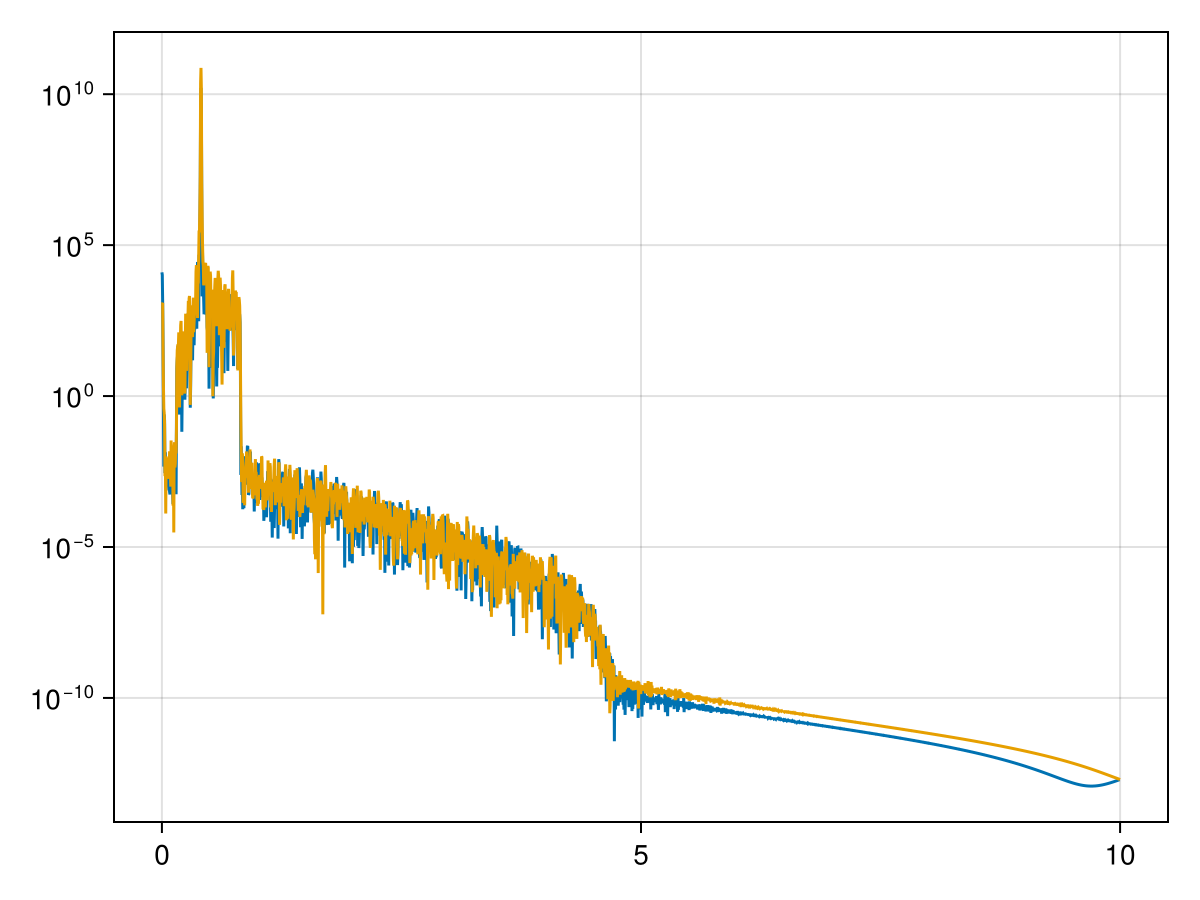

In [36]:
ωs = fftfreq(5002, 1/(t[2] - t[1]))
rotary_wave_h = fft(rotary_wave .* hann(5002))
ωs_uni = ωs[1:2501]
keh = fft(wave_ke .* hann(5002))
f = Figure()
ax = Axis(f[1,1], yscale=log10)
lines!(ax, ωs[1:2501], abs2.(rotary_wave_h)[1:2501])
lines!(ax, -ωs[2502:end], abs2.(rotary_wave_h)[2502:end])
f

In [22]:
ωs

5002-element Frequencies{Float64}:
  0.0
  0.003998400639747739
  0.007996801279495478
  0.011995201919243217
  0.015993602558990957
  0.019992003198738697
  0.023990403838486433
  0.027988804478234174
  0.031987205117981914
  0.035985605757729654
  0.039984006397477394
  0.043982407037225134
  0.04798080767697287
  ⋮
 -0.04798080767697287
 -0.043982407037225134
 -0.039984006397477394
 -0.035985605757729654
 -0.031987205117981914
 -0.027988804478234174
 -0.023990403838486433
 -0.019992003198738697
 -0.015993602558990957
 -0.011995201919243217
 -0.007996801279495478
 -0.003998400639747739

In [26]:
sqrt(18)

4.242640687119285

In [45]:
abs.(keh)

5002-element Vector{Float64}:
      7.187356716839927e7
 759738.6756718701
  56564.29231346337
 335306.2801641998
 269717.9675124258
 193573.75382572095
 153948.99235340086
  46446.05789309048
 178655.23508584552
  46732.114666619964
  18280.54325757611
  72923.01545496943
  40986.093826303004
      ⋮
  40986.09382630294
  72923.0154549695
  18280.543257576024
  46732.114666620095
 178655.23508584555
  46446.05789309062
 153948.99235340086
 193573.75382572066
 269717.9675124258
 335306.2801641998
  56564.29231346338
 759738.6756718701